# __Selecting the Venue to Set up Japanese Ramen Restaurant in Queens__

### Extract and obtain the required data for analysis

#### Import the libraries and packages

In [1]:
import numpy as np
import pandas as pd
import random
import json
from pandas.io.json import json_normalize
import os
import folium
import requests

#### Load the data

In [2]:
# The New York City neighborhood data has been downloaded from NYU Spatial Data Repository and stored in PC.
# change the working directory to assess the json file downloaded
os.chdir("/Users/kean/Desktop/Capstone_Project")

# Load the data
with open('nyu-2451-34572-geojson.json') as json_data:
    newyork = json.load(json_data)

# Extract only the relevant data 
newyork = newyork['features']
newyork


[{'type': 'Feature',
  'id': 'nyu_2451_34572.1',
  'geometry': {'type': 'Point',
   'coordinates': [-73.84720052054902, 40.89470517661]},
  'geometry_name': 'geom',
  'properties': {'name': 'Wakefield',
   'stacked': 1,
   'annoline1': 'Wakefield',
   'annoline2': None,
   'annoline3': None,
   'annoangle': 0.0,
   'borough': 'Bronx',
   'bbox': [-73.84720052054902,
    40.89470517661,
    -73.84720052054902,
    40.89470517661]}},
 {'type': 'Feature',
  'id': 'nyu_2451_34572.2',
  'geometry': {'type': 'Point',
   'coordinates': [-73.82993910812398, 40.87429419303012]},
  'geometry_name': 'geom',
  'properties': {'name': 'Co-op City',
   'stacked': 2,
   'annoline1': 'Co-op',
   'annoline2': 'City',
   'annoline3': None,
   'annoangle': 0.0,
   'borough': 'Bronx',
   'bbox': [-73.82993910812398,
    40.87429419303012,
    -73.82993910812398,
    40.87429419303012]}},
 {'type': 'Feature',
  'id': 'nyu_2451_34572.3',
  'geometry': {'type': 'Point',
   'coordinates': [-73.82780644716412, 

#### Transform the data into a *pandas* DataFrame

In [3]:
# Create a DataFrame with the required columns
columns = ['Neighborhood','Borough', 'Latitude', 'Longitude']
df_newyork = pd.DataFrame(columns = columns)

# Extract and fill in the data into DataFrame
for data in newyork:
    neighborhood = data['properties']['name']
    borough = data['properties']['borough']
    geo = data['geometry']['coordinates']
    lat = geo[1]
    log = geo[0]
    
    df_newyork = df_newyork.append({'Neighborhood':neighborhood, 
                                'Borough':borough, 
                                'Latitude': lat, 
                                'Longitude':log}, ignore_index=True)
df_newyork.head()

,Neighborhood,Borough,Latitude,Longitude
0,Wakefield,Bronx,40.894705,-73.847201
1,Co-op City,Bronx,40.874294,-73.829939
2,Eastchester,Bronx,40.887556,-73.827806
3,Fieldston,Bronx,40.895437,-73.905643
4,Riverdale,Bronx,40.890834,-73.912585


#### Extract the Queens data 

In [4]:
df_queens = df_newyork[df_newyork['Borough']=='Queens'].reset_index(drop = True)
print('There are ', pd.Series(df_queens['Neighborhood'].value_counts().index.tolist()).count(), 'neighborhoods at Queens and the data below shows 5 of them' )
df_queens.head()

There are  81 neighborhoods at Queens and the data below shows 5 of them


,Neighborhood,Borough,Latitude,Longitude
0,Astoria,Queens,40.768509,-73.915654
1,Woodside,Queens,40.746349,-73.901842
2,Jackson Heights,Queens,40.751981,-73.882821
3,Elmhurst,Queens,40.744049,-73.881656
4,Howard Beach,Queens,40.654225,-73.838138


#### Plot the neighborhood of Queens on map

In [5]:
queens_map = folium.Map([40.7282,-73.7949], zoom_start = 11)

# add markers to map
for lat, lng, label in zip(df_queens['Latitude'], df_queens['Longitude'], df_queens['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(queens_map)  
    
queens_map

#### Extract the venue data from Foursquare

In [6]:
# Define Foursquare Credentials and Version
CLIENT_ID = '0HAQB5ARJ14HEQMWKVUPFFKPKLNQPYX0MFR3AAB1SSRVVIUD' # your Foursquare ID
CLIENT_SECRET = '4QTUH2BLKW1JVNNIT3RNXJ5EP0FCEGCJAPUTSJCWTAM2IP2U' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
RADIUS = 3000
LIMIT = 100

# Define a function to extract the required data and saved into a DataFrame
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            RADIUS, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'], 
            v['venue']['location']['distance'], 
            v['venue']['categories'][0]['id'], 
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'Venue', 'Venue ID',
                  'Venue Latitude', 
                  'Venue Longitude', 'Distance', 'Venue Category ID', 'Venue Category']
    
    return(nearby_venues)

queens_venue = getNearbyVenues(df_queens['Neighborhood'], df_queens['Latitude'], df_queens['Longitude'], RADIUS)
queens_venue.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Distance,Venue Category ID,Venue Category
0,Astoria,40.768509,-73.915654,Titan Foods Inc.,4a9c0105f964a520b03520e3,40.769198,-73.919253,312,4bf58dd8d48988d1f5941735,Gourmet Shop
1,Astoria,40.768509,-73.915654,Ample Hills Creamery,5ae115d7c84d18002393461a,40.765562,-73.919012,433,4bf58dd8d48988d1c9941735,Ice Cream Shop
2,Astoria,40.768509,-73.915654,CrossFit Queens,4c94d26d58d4b60c40fc2b29,40.769404,-73.918977,297,4bf58dd8d48988d176941735,Gym
3,Astoria,40.768509,-73.915654,Sitan Muay Thai,5208fbc011d228eef0972843,40.766108,-73.913224,336,4bf58dd8d48988d101941735,Martial Arts Dojo
4,Astoria,40.768509,-73.915654,Al-sham Sweets and Pastries,4ba58abaf964a520d01039e3,40.768077,-73.911561,348,4bf58dd8d48988d115941735,Middle Eastern Restaurant


### Exploratory data analysis

####  Get the top 20 venue category in Queens

The top 20 venue categories in Queens are 

Pizza Place             475
Bakery                  246
Park                    211
Caribbean Restaurant    202
Italian Restaurant      194
Beach                   179
Coffee Shop             162
Chinese Restaurant      150
Ice Cream Shop          150
Bar                     150
Deli / Bodega           141
Bagel Shop              127
Indian Restaurant       114
Thai Restaurant         114
Donut Shop              110
Korean Restaurant       108
Sandwich Place          106
Mexican Restaurant      105
Grocery Store           104
Sushi Restaurant         96
Name: Venue Category, dtype: int64


Text(0.5,0,'Venue Category')

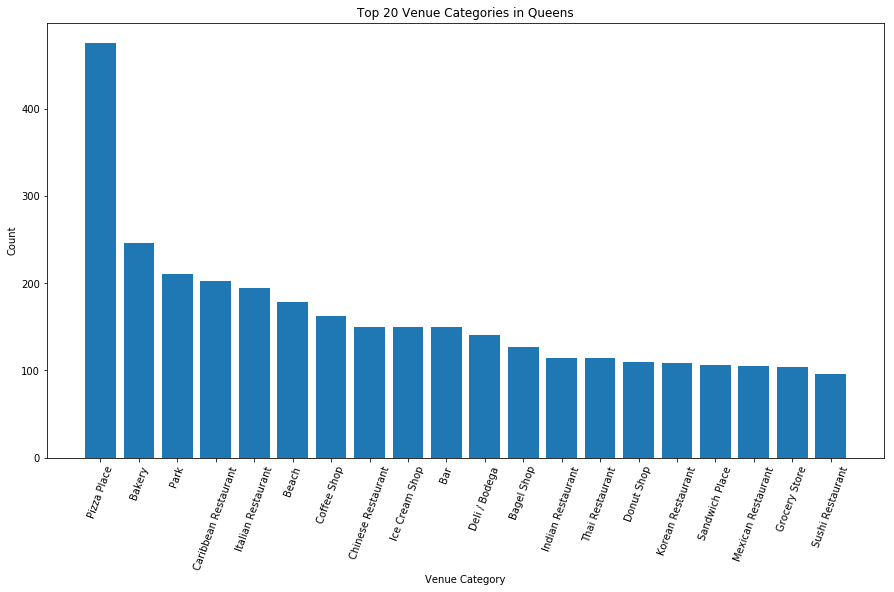

In [7]:
x = queens_venue['Venue Category'].value_counts().index.tolist()[0:20]
y = queens_venue['Venue Category'].value_counts()[0:20]
print('The top 20 venue categories in Queens are \n')
print(y)
import matplotlib.pyplot as plt
%matplotlib inline
fig, axs = plt.subplots(1,1, figsize = (15,8))
axs.bar(x,y)
plt.xticks(rotation = 70)
plt.title('Top 20 Venue Categories in Queens')
plt.ylabel('Count')
plt.xlabel('Venue Category')

#### Filter the data to get venue category  = restaurant

In [8]:
queens_venue['Restaurant'] = queens_venue['Venue Category'].str.contains('Restaurant' or 'Shop')

# Drop the indexes with do not belong to category "Restaurant"
queens_restaurant = queens_venue.copy()
ind = queens_restaurant[queens_restaurant['Restaurant'] == False].index
queens_restaurant.drop(ind, axis = 0, inplace = True)
queens_restaurant_filter = queens_restaurant.reset_index(drop = True)
queens_restaurant_filter.head()


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Distance,Venue Category ID,Venue Category,Restaurant
0,Astoria,40.768509,-73.915654,Al-sham Sweets and Pastries,4ba58abaf964a520d01039e3,40.768077,-73.911561,348,4bf58dd8d48988d115941735,Middle Eastern Restaurant,True
1,Astoria,40.768509,-73.915654,Favela Grill,4bdf502a89ca76b062b75d5e,40.767348,-73.917897,229,4bf58dd8d48988d16b941735,Brazilian Restaurant,True
2,Astoria,40.768509,-73.915654,Seva Indian Cuisine,4aa56c81f964a5204e4820e3,40.765521,-73.919157,444,4bf58dd8d48988d10f941735,Indian Restaurant,True
3,Astoria,40.768509,-73.915654,Duzan,4b427919f964a52093d425e3,40.768730,-73.911013,391,4bf58dd8d48988d10b941735,Falafel Restaurant,True
4,Astoria,40.768509,-73.915654,Sabry's,4bbfe9634cdfc9b6bd369221,40.768446,-73.911267,369,4bf58dd8d48988d1ce941735,Seafood Restaurant,True


#### Get the top 20 restaurant category in Queens

The top 20 Restaurant categories in Queens are 

Caribbean Restaurant         202
Italian Restaurant           194
Chinese Restaurant           150
Thai Restaurant              114
Indian Restaurant            114
Korean Restaurant            108
Mexican Restaurant           105
Sushi Restaurant              96
Greek Restaurant              82
Japanese Restaurant           75
Fast Food Restaurant          71
South American Restaurant     70
Restaurant                    67
Latin American Restaurant     66
American Restaurant           65
Seafood Restaurant            58
Asian Restaurant              50
Vietnamese Restaurant         32
Mediterranean Restaurant      32
Peruvian Restaurant           32
Name: Venue Category, dtype: int64


Text(0.5,0,'Restaurant Category')

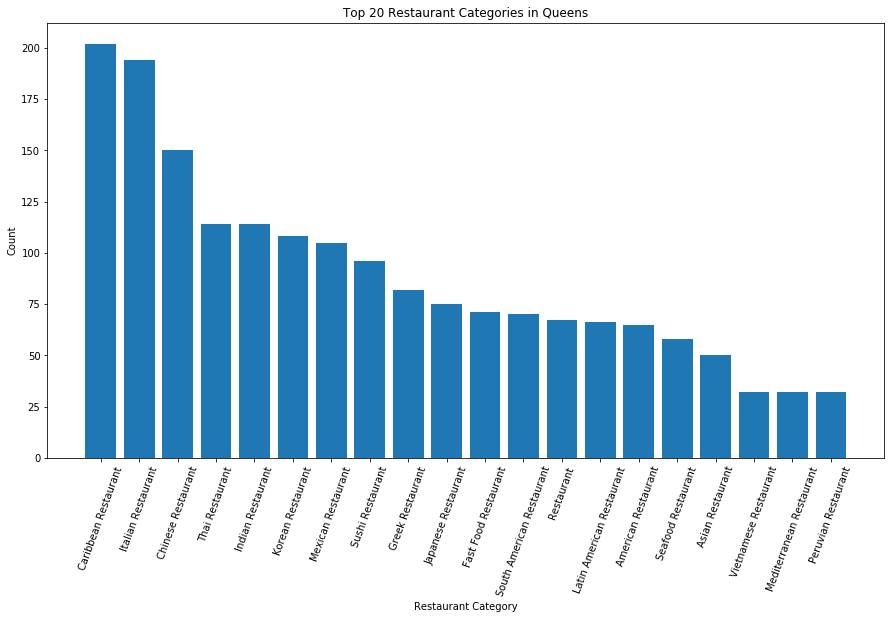

In [9]:
x = queens_restaurant_filter['Venue Category'].value_counts().index.tolist()[0:20]
y = queens_restaurant_filter['Venue Category'].value_counts()[0:20]
print('The top 20 Restaurant categories in Queens are \n')
print(y)
import matplotlib.pyplot as plt
%matplotlib inline
fig, axs = plt.subplots(1,1, figsize = (15,8))
axs.bar(x,y)
plt.xticks(rotation = 70)
plt.title('Top 20 Restaurant Categories in Queens')
plt.ylabel('Count')
plt.xlabel('Restaurant Category')

#### Get the top 10 neighborhoods with the most restaurant

The top 10 neighborhoods with the most restaurants are 

Elmhurst           65
Jackson Heights    64
Woodside           50
Maspeth            50
Murray Hill        47
Flushing           47
South Jamaica      44
Jamaica Center     43
Lefrak City        42
Pomonok            39
Name: Neighborhood, dtype: int64


Text(0,0.5,'Count')

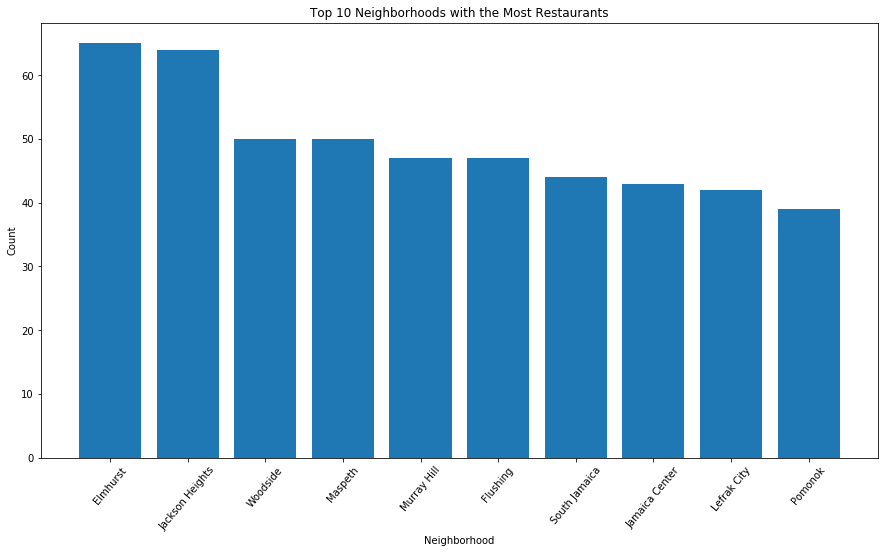

In [435]:
x = queens_restaurant_filter['Neighborhood'].value_counts().index.tolist()[0:10]
y = queens_restaurant_filter['Neighborhood'].value_counts()[0:10]
fig, axs = plt.subplots(1,1, figsize = (15,8))
print('The top 10 neighborhoods with the most restaurants are \n',)
print(y)
axs.bar(x, y)
plt.xticks(rotation = 50)
plt.title('Top 10 Neighborhoods with the Most Restaurants')
axs.set_xlabel('Neighborhood')
axs.set_ylabel('Count')

#### Find the all the Ramen restaurants in Queens

In [10]:
queens_venue['Ramen'] = queens_venue['Venue Category'].str.contains('Ramen')

# Drop the indexes with do not belong to category "Ramen"
queens_ramen = queens_venue.copy()
ind = queens_ramen[queens_ramen['Ramen'] == False].index
queens_ramen.drop(ind, axis = 0, inplace = True)
queens_ramen_filter = queens_ramen.reset_index(drop = True)
print('There are',queens_ramen_filter.shape[0], 'Ramen restaurants at Queens\n')
print('The Ramen restaurants are at the neighborhood below \n', queens_ramen['Neighborhood'].value_counts().index.tolist())

There are 10 Ramen restaurants at Queens

The Ramen restaurants are at the neighborhood below 
 ['Astoria Heights', 'Woodside', 'Sunnyside', 'Forest Hills', 'Kew Gardens Hills', 'Sunnyside Gardens', 'Blissville', 'Forest Hills Gardens', 'Steinway', 'Long Island City']


#### Analyze each neighborhood

In [20]:
# one hot encoding
queens_venue_onehot = pd.get_dummies(queens_venue[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
queens_venue_onehot['Neighborhood'] = queens_venue['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [queens_venue_onehot.columns[-1]] + list(queens_venue_onehot.columns[:-1])
queens_venue_onehot = queens_venue_onehot[fixed_columns]

queens_venue_grouped = queens_venue_onehot.groupby('Neighborhood').mean().reset_index()

###
num_top_venues = 5

for hood in queens_venue_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = queens_venue_grouped[queens_venue_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Arverne----
           venue  freq
0          Beach  0.30
1      Surf Spot  0.07
2      Beach Bar  0.04
3       Wine Bar  0.04
4  Grocery Store  0.04


----Astoria----
                venue  freq
0    Greek Restaurant  0.07
1                 Bar  0.05
2  Italian Restaurant  0.05
3              Bakery  0.05
4          Bagel Shop  0.05


----Astoria Heights----
              venue  freq
0               Bar  0.08
1            Bakery  0.06
2  Greek Restaurant  0.05
3       Pizza Place  0.05
4        Bagel Shop  0.03


----Auburndale----
               venue  freq
0  Korean Restaurant  0.17
1         Bagel Shop  0.04
2        Pizza Place  0.04
3        Coffee Shop  0.04
4   Greek Restaurant  0.04


----Bay Terrace----
                venue  freq
0         Pizza Place  0.07
1                Park  0.05
2  Italian Restaurant  0.05
3              Bakery  0.05
4      Cosmetics Shop  0.04


----Bayside----
               venue  freq
0             Bakery  0.07
1        Pizza Place  0.05
2     

                venue  freq
0         Pizza Place  0.10
1  Italian Restaurant  0.06
2      Discount Store  0.05
3               Diner  0.04
4         Supermarket  0.04


----Little Neck----
                venue  freq
0         Pizza Place  0.07
1  Italian Restaurant  0.04
2       Grocery Store  0.04
3              Bakery  0.04
4        Burger Joint  0.04


----Long Island City----
                venue  freq
0                Park  0.04
1  Mexican Restaurant  0.04
2         Coffee Shop  0.04
3    Sushi Restaurant  0.04
4         Pizza Place  0.04


----Malba----
               venue  freq
0        Pizza Place  0.09
1      Deli / Bodega  0.08
2               Park  0.08
3  Korean Restaurant  0.05
4        Supermarket  0.04


----Maspeth----
                venue  freq
0     Thai Restaurant  0.09
1         Pizza Place  0.08
2  Mexican Restaurant  0.07
3                 Bar  0.07
4              Bakery  0.05


----Middle Village----
                 venue  freq
0          Pizza Place  0.10


## Machine Learning Modeling

#### Get the top 10 most common venue at each neightborhood

In [21]:
# Define the function to get the top 10 most common venues at each neighborhood
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# Create the Dataframe to store the top 10 most common venues at each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = queens_venue_grouped['Neighborhood']


for ind in np.arange(df_queens.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(queens_venue_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arverne,Beach,Surf Spot,Beach Bar,Wine Bar,Pizza Place,Grocery Store,Supermarket,Taco Place,Chinese Restaurant,Eastern European Restaurant
1,Astoria,Greek Restaurant,Bagel Shop,Bakery,Bar,Italian Restaurant,Food Truck,Sushi Restaurant,Thai Restaurant,Pizza Place,Grocery Store
2,Astoria Heights,Bar,Bakery,Greek Restaurant,Pizza Place,Bagel Shop,Sushi Restaurant,Italian Restaurant,Irish Pub,Gourmet Shop,Gym
3,Auburndale,Korean Restaurant,Bagel Shop,Greek Restaurant,Pizza Place,Coffee Shop,Indian Restaurant,Ice Cream Shop,Liquor Store,Park,Pharmacy
4,Bay Terrace,Pizza Place,Italian Restaurant,Park,Bakery,Greek Restaurant,Bagel Shop,Cosmetics Shop,Gym / Fitness Center,Ice Cream Shop,Korean Restaurant


#### Finding optimum *k* - Elbow Method

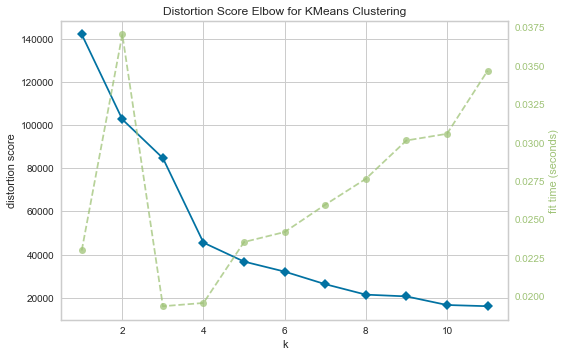

In [37]:
#Clean the dataframe
new_ml = pd.get_dummies(queens_venue, columns = ['Venue Category'])
new_ml_group = new_ml.groupby(['Neighborhood']).mean().reset_index()
new_ml_KM = new_ml_group.drop(['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Latitude', 'Venue Longitude'], axis = 1)

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Elbow Method analysis
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))

visualizer.fit(new_ml_KM)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

### KMeans clustering modeling

In [41]:
kmean = KMeans(n_clusters = 4, init = "k-means++")
kmean.fit(new_ml_KM)

# check cluster labels generated for each row in the dataframe
kmean.labels_[0:10] 

array([1, 0, 1, 3, 2, 3, 2, 2, 2, 1], dtype=int32)

In [114]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmean.labels_)

# Clean the data to get the final table containing the most common venues, cluster labels, distance and restaurant
new_ml_KM['Neighborhood'] = new_ml_group['Neighborhood']
new_ml_merged = new_ml_KM

new_ml_merged = new_ml_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

new_ml_final = new_ml_merged[['Neighborhood','Cluster Labels', 'Distance', 'Restaurant', 'Ramen', '1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue', '4th Most Common Venue', '5th Most Common Venue']]
new_ml_final.head()

,Neighborhood,Cluster Labels,Distance,Restaurant,Ramen,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Arverne,1,1739.722222,0.12963,0.00,Beach,Surf Spot,Beach Bar,Wine Bar,Pizza Place
1,Astoria,0,677.220000,0.33000,0.00,Greek Restaurant,Bagel Shop,Bakery,Bar,Italian Restaurant
2,Astoria Heights,1,1640.640000,0.31000,0.01,Bar,Bakery,Greek Restaurant,Pizza Place,Bagel Shop
3,Auburndale,3,1281.590000,0.34000,0.00,Korean Restaurant,Bagel Shop,Greek Restaurant,Pizza Place,Coffee Shop
4,Bay Terrace,2,1901.840000,0.29000,0.00,Pizza Place,Italian Restaurant,Park,Bakery,Greek Restaurant


### Plot the neighborhood in map according to their clusters

In [64]:
import matplotlib.colors as colors
# create map
map_clusters = folium.Map(location= [40.7282,-73.7949], zoom_start=11)

n_clusters = 4
# set color scheme for the clusters
x = np.arange(n_clusters)
ys = [i + x + (i*x)**2 for i in range(n_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(new_ml_group['Neighborhood Latitude'], new_ml_group['Neighborhood Longitude'], new_ml_merged['Neighborhood'], new_ml_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Individual cluster analysis

#### Cluster 1 analysis

In [81]:
queens_cluster_1 = new_ml_final.loc[new_ml_final['Cluster Labels'] == 0, new_ml_final.columns ]
print(queens_cluster_1['1st Most Common Venue'].value_counts().index.tolist()[0] , 
      'is ranked the most in 1st most common venue in the cluster 1 neighborhood with total' , 
      queens_cluster_1['1st Most Common Venue'].value_counts()[0] , 'counts')
print()
print(queens_cluster_1['2nd Most Common Venue'].value_counts().index.tolist()[0] , 
      'is ranked the most in 2nd most common venue in the cluster 1 neighborhood with total' , 
      queens_cluster_1['2nd Most Common Venue'].value_counts()[0] , 'counts')
print()
print('The average distance from the neighborhood center is ', queens_cluster_1['Distance'].mean(), 'm')
print('Average restaurant probability is ', queens_cluster_1['Restaurant'].mean())
queens_cluster_1

Thai Restaurant is ranked the most in 1st most common venue in the cluster 1 neighborhood with total 2 counts

Bakery is ranked the most in 2nd most common venue in the cluster 1 neighborhood with total 3 counts

The average distance from the neighborhood center is  812.0950000000001 m
Average restaurant probability is  0.4516666666666667


,Neighborhood,Cluster Labels,Distance,Restaurant,Ramen,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Astoria,0,677.22,0.33,0.00,Greek Restaurant,Bagel Shop,Bakery,Bar,Italian Restaurant
22,Elmhurst,0,777.37,0.65,0.00,Thai Restaurant,Bakery,Indian Restaurant,South American Restaurant,Mexican Restaurant
25,Flushing,0,789.80,0.46,0.00,Chinese Restaurant,Korean Restaurant,Bubble Tea Shop,Tennis Stadium,Dumpling Restaurant
26,Forest Hills,0,975.46,0.35,0.01,Bakery,Pizza Place,Italian Restaurant,Sushi Restaurant,Bagel Shop
27,Forest Hills Gardens,0,821.60,0.28,0.01,Pizza Place,Bakery,Park,Italian Restaurant,Bagel Shop
37,Jackson Heights,0,831.12,0.64,0.00,Thai Restaurant,Bakery,Indian Restaurant,Mexican Restaurant,South American Restaurant


#### Cluster 2 analysis

In [107]:
queens_cluster_2 = new_ml_final.loc[new_ml_final['Cluster Labels'] == 1, new_ml_final.columns ]
print(queens_cluster_2['1st Most Common Venue'].value_counts().index.tolist()[0] , 
      'is ranked the most in 1st most common venue in the cluster 2 neighborhood with total' , 
      queens_cluster_2['1st Most Common Venue'].value_counts()[0] , 'counts')
print()
print(queens_cluster_2['2nd Most Common Venue'].value_counts().index.tolist()[0] , 
      'is ranked the most in 2nd most common venue in the cluster 2 neighborhood with total' , 
      queens_cluster_2['2nd Most Common Venue'].value_counts()[0] , 'counts')
print()
print('The average distance from the neighborhood center is ', queens_cluster_2['Distance'].mean(), 'm')
print('Average restaurant probability is ', queens_cluster_2['Restaurant'].mean())
queens_cluster_2

Pizza Place is ranked the most in 1st most common venue in the cluster 2 neighborhood with total 14 counts

Italian Restaurant is ranked the most in 2nd most common venue in the cluster 2 neighborhood with total 4 counts

The average distance from the neighborhood center is  1710.0442900181743 m
Average restaurant probability is  0.27363500416308967


,Neighborhood,Cluster Labels,Distance,Restaurant,Ramen,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Arverne,1,1739.722222,0.129630,0.00,Beach,Surf Spot,Beach Bar,Wine Bar,Pizza Place
2,Astoria Heights,1,1640.640000,0.310000,0.01,Bar,Bakery,Greek Restaurant,Pizza Place,Bagel Shop
9,Belle Harbor,1,1657.266667,0.160000,0.00,Beach,Ice Cream Shop,Pizza Place,Pharmacy,Deli / Bodega
11,Blissville,1,1828.450000,0.300000,0.01,Coffee Shop,Mexican Restaurant,Café,Yoga Studio,Bar
17,College Point,1,1793.170000,0.270000,0.00,Chinese Restaurant,Korean Restaurant,Deli / Bodega,Gym,Park
23,Far Rockaway,1,1749.535714,0.119048,0.00,Beach,Pizza Place,Supermarket,Chinese Restaurant,Golf Course
24,Floral Park,1,1818.810000,0.210000,0.00,Pizza Place,Indian Restaurant,Italian Restaurant,Park,Deli / Bodega
30,Glendale,1,1750.840000,0.230000,0.00,Pizza Place,Italian Restaurant,Bakery,Deli / Bodega,German Restaurant
32,Hillcrest,1,1633.500000,0.360000,0.00,Pizza Place,Coffee Shop,Park,Mexican Restaurant,Chinese Restaurant
35,Howard Beach,1,1603.920000,0.190000,0.00,Pizza Place,Italian Restaurant,Discount Store,Deli / Bodega,Diner


#### Cluster 3 analysis

In [108]:
queens_cluster_3 = new_ml_final.loc[new_ml_final['Cluster Labels'] == 2, new_ml_final.columns ]
print(queens_cluster_3['1st Most Common Venue'].value_counts().index.tolist()[0] , 
      'is ranked the most in 1st most common venue in the cluster 3 neighborhood with total' , 
      queens_cluster_3['1st Most Common Venue'].value_counts()[0] , 'counts')
print()
print(queens_cluster_3['2nd Most Common Venue'].value_counts().index.tolist()[0] , 
      'is ranked the most in 2nd most common venue in the cluster 3 neighborhood with total' , 
      queens_cluster_3['2nd Most Common Venue'].value_counts()[0] , 'counts')
print()
print('The average distance from the neighborhood center is ', queens_cluster_3['Distance'].mean(), 'm')
print('Average restaurant probability is ', queens_cluster_3['Restaurant'].mean())
queens_cluster_3

Pizza Place is ranked the most in 1st most common venue in the cluster 3 neighborhood with total 14 counts

Pizza Place is ranked the most in 2nd most common venue in the cluster 3 neighborhood with total 7 counts

The average distance from the neighborhood center is  2048.7786062330188 m
Average restaurant probability is  0.25776414174359386


,Neighborhood,Cluster Labels,Distance,Restaurant,Ramen,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
4,Bay Terrace,2,1901.840000,0.290000,0.0,Pizza Place,Italian Restaurant,Park,Bakery,Greek Restaurant
6,Bayswater,2,2183.203704,0.055556,0.0,Pizza Place,Beach,Donut Shop,Sandwich Place,Pharmacy
7,Beechhurst,2,1951.350000,0.180000,0.0,Pizza Place,Deli / Bodega,Italian Restaurant,Park,Donut Shop
8,Bellaire,2,2090.650000,0.230000,0.0,Pizza Place,Park,Indian Restaurant,Bank,Discount Store
10,Bellerose,2,2095.050000,0.200000,0.0,Pizza Place,Park,Indian Restaurant,Bakery,Italian Restaurant
12,Breezy Point,2,2065.875000,0.041667,0.0,Beach,Bar,Bus Stop,Café,Scenic Lookout
13,Briarwood,2,1908.110000,0.340000,0.0,Pizza Place,Caribbean Restaurant,Coffee Shop,Bar,Vegetarian / Vegan Restaurant
14,Broad Channel,2,2167.111111,0.111111,0.0,Beach,Surf Spot,Bagel Shop,Beach Bar,Wine Bar
15,Brookville,2,2183.620000,0.200000,0.0,Caribbean Restaurant,Clothing Store,Donut Shop,Park,Pizza Place
16,Cambria Heights,2,2131.880000,0.280000,0.0,Caribbean Restaurant,Pizza Place,Pharmacy,Donut Shop,Discount Store


#### Cluster 4 analysis

In [109]:
queens_cluster_4 = new_ml_final.loc[new_ml_final['Cluster Labels'] == 3, new_ml_final.columns ]
print(queens_cluster_4['1st Most Common Venue'].value_counts().index.tolist()[0] , 
      'is ranked the most in 1st most common venue in the cluster 4 neighborhood with total' , 
      queens_cluster_4['1st Most Common Venue'].value_counts()[0] , 'counts')
print()
print(queens_cluster_4['2nd Most Common Venue'].value_counts().index.tolist()[0] , 
      'is ranked the most in 2nd most common venue in the cluster 4 neighborhood with total' , 
      queens_cluster_4['2nd Most Common Venue'].value_counts()[0] , 'counts')
print()
print('The average distance from the neighborhood center is ', queens_cluster_4['Distance'].mean(), 'm')
print('Average restaurant probability is ', queens_cluster_4['Restaurant'].mean())
queens_cluster_4

Bakery is ranked the most in 1st most common venue in the cluster 4 neighborhood with total 2 counts

Bagel Shop is ranked the most in 2nd most common venue in the cluster 4 neighborhood with total 2 counts

The average distance from the neighborhood center is  1296.2743672456575 m
Average restaurant probability is  0.32560794044665015


,Neighborhood,Cluster Labels,Distance,Restaurant,Ramen,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,Auburndale,3,1281.590000,0.340000,0.00,Korean Restaurant,Bagel Shop,Greek Restaurant,Pizza Place,Coffee Shop
5,Bayside,3,1086.790000,0.290000,0.00,Bakery,Pizza Place,Cosmetics Shop,Korean Restaurant,Greek Restaurant
18,Corona,3,1391.490000,0.350000,0.00,Tennis Stadium,South American Restaurant,Pizza Place,Bakery,Park
31,Hammels,3,1376.096774,0.112903,0.00,Beach,Surf Spot,Bagel Shop,Pizza Place,Beach Bar
44,Lefrak City,3,1359.640000,0.430000,0.00,Tennis Stadium,Thai Restaurant,Bakery,Pizza Place,Park
51,Murray Hill,3,1209.640000,0.460000,0.00,Korean Restaurant,Chinese Restaurant,Bubble Tea Shop,Dumpling Restaurant,Coffee Shop
60,Ravenswood,3,1322.380000,0.260000,0.00,Bar,Bagel Shop,Park,Italian Restaurant,Coffee Shop
61,Rego Park,3,1135.650000,0.350000,0.00,Bakery,Italian Restaurant,Cosmetics Shop,American Restaurant,Pizza Place
63,Ridgewood,3,1412.590000,0.280000,0.00,Bar,Mexican Restaurant,Bakery,Coffee Shop,Nightclub
66,Rockaway Park,3,1447.440000,0.150000,0.00,Beach,Pizza Place,Ice Cream Shop,Bagel Shop,Bar


#### Concentration of restaurants from neighborhood center

,Distance from Center,Restaurant Percentage,Cluster
0,812.095000,0.451667,1
1,1296.274367,0.325608,4
2,1710.044290,0.273635,2
3,2048.778606,0.257764,3


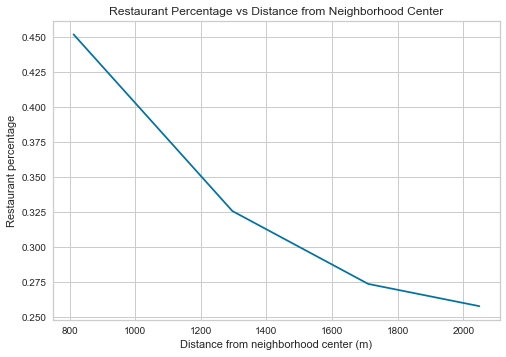

In [110]:
x = [queens_cluster_1['Distance'].mean(), queens_cluster_4['Distance'].mean(), queens_cluster_2['Distance'].mean(), queens_cluster_3['Distance'].mean()]
y = [queens_cluster_1['Restaurant'].mean(), queens_cluster_4['Restaurant'].mean(), queens_cluster_2['Restaurant'].mean(), queens_cluster_3['Restaurant'].mean()]
columns = ['Distance from Center', 'Restaurant Percentage','Cluster']
summary_table = pd.DataFrame(columns = columns)
summary_table['Distance from Center'] = x
summary_table['Restaurant Percentage'] = y
summary_table['Cluster'] = [1,4,2,3]

plt.plot(x,y)
plt.title('Restaurant Percentage vs Distance from Neighborhood Center')
plt.xlabel('Distance from neighborhood center (m)')
plt.ylabel('Restaurant percentage')

summary_table